### Model 1 

Forecast Price per meter^2 by district

**Question(s) to Answer:**

- How will the prices per square meter and per disctric will change the next quarter? (Fixed at 2009)

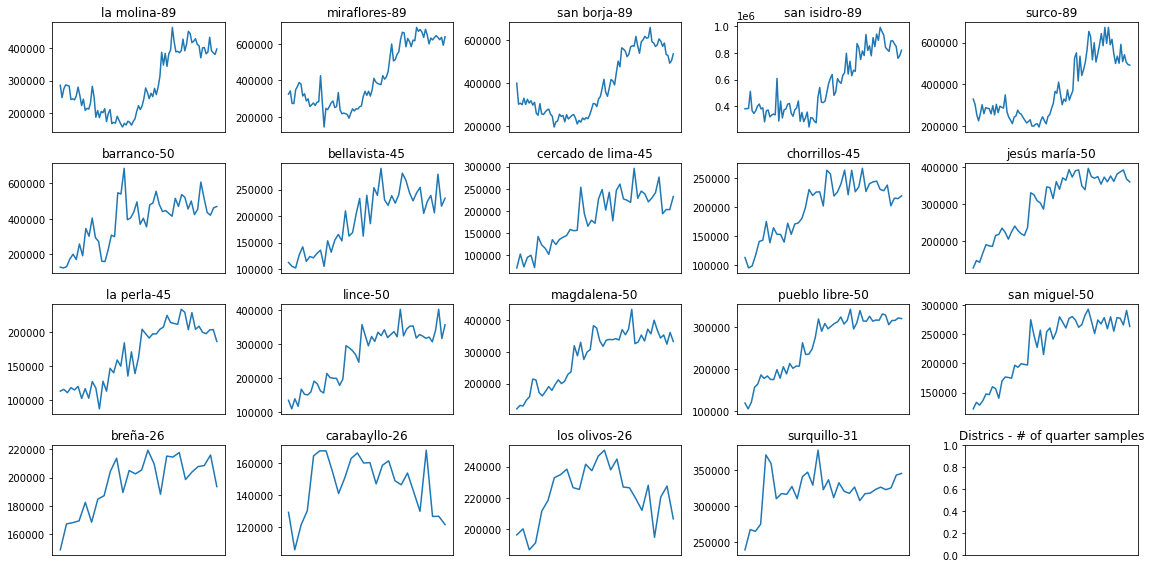

In [1]:
import pandas as pd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

from itertools import product
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns',None)

#Apartments data
data = pd.read_excel('../input/BCRP-depas.xlsx')
data['Periodo'] = data['Año'].astype(str) + '_' + data['Trimestre'].astype(str)
data['Distrito'] = data['Distrito'].str.lower()
#Macroeconomic data
macro_data = pd.read_csv('../input/macro_data/macro-1999-2019-1.csv')
macro_data['Fecha'] = pd.to_datetime(macro_data['Fecha'])
#Replacement of Excel LineBreaks
data = data.replace('_x000D_','',regex=True)

#Basic EDA
#Time Series behavior. It seems all have the same movement.
ts_districts = data.groupby(['Periodo','Distrito'])['Precio en soles constantes de 2009'].median().reset_index()

fig, axes = plt.subplots(4,5, figsize=(16,8))

tuples_axes = tuple(product([0,1,2,3,4],repeat=2))

for tuple_, district in zip(tuples_axes[:-6],ts_districts['Distrito'].unique()):
    df = ts_districts[ts_districts['Distrito'] == district]
    sns.lineplot(ax = axes[tuple_[0],tuple_[1]], x = df['Periodo'].values, y=df['Precio en soles constantes de 2009'].values)
    axes[tuple_[0],tuple_[1]].set_title(district + '-'+ str(df['Periodo'].nunique()))

plt.setp(axes, xticks=[])

plt.title('Districs - # of quarter samples')
fig.tight_layout()
plt.show()

# To simplify the problem we will only work with the following districts:

prototyping_districts = ['surco', 'miraflores', 'la molina', 'san borja', 'san isidro', 
                         'san miguel', 'magdalena', 'jesús maría', 'pueblo libre', 'lince', 'barranco']

df = data[data['Distrito'].isin(prototyping_districts)]

#At this point, we will not think too much about the reason of the nan values. We chosen to
#replace NaN values with the mode per district and year.

spec_columns = ['Número de habitaciones', 'Número de baños',
       'Número de garajes', 'Piso de ubicación', 'Vista al exterior',
       'Años de antigüedad'] #specific columns for nan apartment columns

mode_groupby_data = df.groupby(['Distrito'])[spec_columns].agg(lambda x: x.mode()[0]) #which index is the district

for district in df['Distrito'].unique():
    for nan_col in spec_columns:
        index_nan_temp = df[(df['Distrito'] == district)&(df[nan_col].isna())].index
        warnings.filterwarnings('ignore')
        df.loc[index_nan_temp, nan_col] = mode_groupby_data[mode_groupby_data.index.str.contains(district)][nan_col].values[0]
        
#Transform Price and Surface to logs
#df['Precio en soles constantes de 2009'] = np.log(df['Precio en soles constantes de 2009'])
#df['Superficie '] = np.log(df['Superficie '])

df['Precio_m2'] = df['Precio en soles constantes de 2009'] / df['Superficie ']

df['Precio_m2'] = np.log(df['Precio_m2'])

#Mapping numeric columns (años de antiguedad) into categories
df['antiguedad_cat'] = pd.cut(df['Años de antigüedad'], 5, labels=['nuevo','seminuevo','normal','viejo','muy viejo'])

#Mapping numeric location floor into categories
df['piso_cat'] = pd.cut(df['Piso de ubicación'], 3, labels=['bajo','medio','alto'])

#drop erratic data
df.drop(df[df['Número de habitaciones'] == 0].index,inplace=True)

**We will reshape the dataset for time series analysis**

In [2]:
df.drop(['Año','Trimestre','Precio en dólares corrientes','Precio en soles corrientes','Precio en soles constantes de 2009'],axis=1, inplace=True)

#Formatting date time
df['Periodo']=df['Periodo'].map({x :((pd.to_datetime(x[:4]) + pd.offsets.QuarterEnd(int(x[5:]))) + datetime.timedelta(days=1))\
                                 for x in df['Periodo'].unique()}).dt.floor('D')

df.rename(columns={'Periodo':'Fecha'},inplace=True)

#Merge with Macro data:
to_train = df.merge(macro_data, on='Fecha',how='left').dropna()

In [3]:
#In order to make apartment characteristics unique, we will use PCA as an proxy indicator for that

#Encode categorical variables: Distrito, antiguedad_cat, piso_cat
from sklearn.preprocessing import LabelEncoder

dict_encoders = {}
for col in ['Distrito','antiguedad_cat','piso_cat']:
    #We will keep a record from labelEncoder objects as we'll to inverse_transform the values
    le = LabelEncoder()
    le.fit(to_train[col].values)
    dict_encoders[col] = le
    to_train[col] = le.transform(to_train[col].values)

In [4]:
to_train[['Número de habitaciones', 'Número de baños','Número de garajes', 'Vista al exterior','piso_cat']] = to_train[['Número de habitaciones', 'Número de baños','Número de garajes', 'Vista al exterior','piso_cat']].astype('int32')

X_to_reduce = to_train[['Número de habitaciones', 'Número de baños','Número de garajes', 'Vista al exterior','piso_cat']]

#PCA as an index of multiple apartments characteristics.
from sklearn.decomposition import PCA

pca_1d = PCA(n_components=1)
values_1d = pca_1d.fit_transform(X_to_reduce)

print('Shape: {} \n Unique values {}'.format(values_1d.shape, len(np.unique(values_1d))))

to_train['PCA_comp'] = values_1d

#Shifting values and transforming to positive ones.
to_train['PCA_comp'] = to_train['PCA_comp'] + abs(to_train['PCA_comp'].min())

#Each PCA_comp its an expression of unique apartment structure e.g.
#an apartment on La Molina and with 3 bedrooms, 1 bathroom, 1 garage, exterior view, and on the top floor 
#will have the same PCA_comp values with another one with this same characteristics.
#This serves us as a proxy to identify the same apartment through time.

Shape: (51593, 1) 
 Unique values 378


In [5]:
#we have to explain this std with the other features
to_train.to_csv('../input/preprocess_data/to_train.csv')
#Can we make more accurate proxy of unique houses?
#At this time we will not demonstrate that this houses are the same throught time
#Neither we will prove that this are cotinuous time. Due to the fact that are few samples
#to_train.groupby(['PCA_comp','Superficie ','Piso de ubicación'])['Fecha'].agg('count').reset_index()['Fecha'].value_counts()
#we can also try with ANOVA test in order to realize that we should need more data (features)

##### Doing lags for the data:

In [6]:
def make_dataframe_with_lags(data, start_date, end_date, agg_dictionary, columns_to_pivot, datecol = 'Fecha',
                            index_col='PCA_comp'):
    """
    Pass data and obtain a dataframe with past values as columns, and also a
    Y column to use as a target feature.
    
    I need to:
    Aggregated methods by dictionary.
    From quarter to another.
    With index attached to it.
    """
    
    #The end_date will be use for making the target:
    temp_df = data[(data[datecol] >= start_date)&(data[datecol] < end_date)]
    #standarize columns names
    dict_repl_dates = {elem:'LAG_'+str(n) for n,elem in enumerate(np.sort(temp_df[datecol].unique())[::-1],1)}
    temp_df[datecol].replace(dict_repl_dates, inplace=True)
    #Pivot table for macro data
    macro_lags = pd.pivot_table(temp_df, values=columns_to_pivot, index=index_col, 
                       columns=datecol, aggfunc=agg_dictionary).ffill().bfill().reset_index() #Careful with ffill & bfill
    macro_lags.columns = macro_lags.columns.map('_'.join).str.strip('_')
    #Creating lagged targets:

    lagged_targets = pd.pivot_table(temp_df, values='Precio_m2',index=['PCA_comp','Distrito'], columns='Fecha').reset_index()

    #Creo una dummy para luego reemplazar los lagged_targets
    for lag_col in ['LAG_1','LAG_2','LAG_3','LAG_4']:
        lagged_targets[lag_col+'_isna'] = 0
        lagged_targets[lag_col+'_isna'].iloc[lagged_targets[lagged_targets[lag_col].isna()].index] = 1
    
    X = lagged_targets.iloc[:,:6]
    imputer = KNNImputer(n_neighbors=5)
    imputed_lagged_targets = imputer.fit_transform(X)

    lagged_targets.iloc[:,:6] = pd.DataFrame(imputed_lagged_targets, columns = lagged_targets.iloc[:,:6].columns)
    
    #Actual target. The next period is the target price I want.
    
    main_train = data[data[datecol] == end_date]
    main_target = main_train.groupby(['PCA_comp','Distrito'])['Precio_m2'].median().reset_index().rename(columns={'Precio_m2':'target'})
    #Merge final dataframe
    macro_lagged = macro_lags.merge(lagged_targets, on='PCA_comp',how='left')
    final_df = macro_lagged.merge(main_target, on=['PCA_comp','Distrito'],how='left').dropna()
    
    return final_df

In [7]:
def make_training_dataframe(data, window_size = 60, agg_dictionary = np.mean):
    
    """
    Make the entire dataframe for training.
    
    Per PCA and district
    """
    
    macroeconomics_indx_col = ['PBI ', 'Ratio adul-joven','TI Trimestral', 'Tasa hipotecaria Trimestral', 
                           'CaptBurs Trimestral','INB']
    lista_df = []
    
    #Making train dataset with expanding window approach
    for n in range(0,window_size):
        dates_array = np.sort(data['Fecha'].unique())[n:n+5]
        sample_df = make_dataframe_with_lags(data, start_date = dates_array[0], end_date=dates_array[-1],
                                     agg_dictionary = np.mean,
                                    columns_to_pivot=macroeconomics_indx_col)
        lista_df.append(sample_df)    
    train_data = pd.concat(lista_df).reset_index(drop=True)
    print('TRAIN_DATA: From {} to {}'.format(dates_array[0], dates_array[-1]))
    #Making test dataset with the next period.
    
    testing_dates_array = np.sort(data['Fecha'].unique())[n+1:n+1+5]
    
    assert len(testing_dates_array) == 5
    
    testing_data = make_dataframe_with_lags(data, start_date = testing_dates_array[0], 
                                                end_date = testing_dates_array[-1], agg_dictionary = np.mean,
                                               columns_to_pivot=macroeconomics_indx_col).reset_index(drop=True)

    #print(f'LAST DATE TRAIN:{dates_array[-1]}')
    #print(f'TESTING DATE: {testing_dates_array[-1]}')
    
    return train_data, testing_data, testing_dates_array[-1]

#Formatting data_districts_pred

def formatting_predictions(dict_districts):
    """
    dict_districts: A dictionary with datetime as index, and a subdict with 'Distrito' & 'actuals|predictions'
    This will return us two matrixes, one of predictions and the other of actuals values.
    In order to compare their metrics.
    
    """
    data_districts = pd.DataFrame().from_dict({(outerKey, innerKey) : values for outerKey, innerDict in dict_districts.items() for innerKey, values in innerDict.items()})
    #Duplicate columns
    data_districts.columns = [str(tup[0]) if tup[1] != 'Distrito' else tup[1] for tup in data_districts.columns]
    data_districts = data_districts.loc[:, ~data_districts.columns.duplicated()].set_index('Distrito').T
    data_districts.columns.names = [None]
    
    return data_districts

def calculate_mape(actual, prediction):
        mask = actual != 0
        return (np.fabs(actual - prediction)/actual)[mask].mean()

def subdict_metrics(actuals, preds):
    """
    This function is made to build a dictionary that contains metrics.
    """
    #Calculating metrics:
    mae = mean_absolute_error(actuals, preds)
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(np.mean(np.power(np.log(np.array(abs(preds))+1) - np.log(np.array(abs(actuals))+1), 2)))
    r2 = r2_score(actuals,preds)
    mape = calculate_mape(actuals, preds)
    #Since doesn't matter how many time the algorithm will train, we don't add this metrics.
    
    return {'MAE': mae, 'MSE': mse, 'RMSE' : rmse, 'R2' : r2,
                                  'RMSLE' : rmsle, 'MAPE' : mape}

In [8]:
#EXPANDING WINDOW BACKTESTING -> Basic Linear Regression:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.core.display import HTML

predictions_dict = {}
original_values_dict = {}

dict_districts_preds = {} 
dict_districts_actuals = {}

dict_districs_metrics = {district: [] for district in prototyping_districts }
final_metrics_df = pd.DataFrame()

for n in range(60, len(to_train['Fecha'].unique()[:-5])):
    
    #Initializing values:
    
    #iterate with expanding window dataset.
    training_data, testing_data, testing_date = make_training_dataframe(to_train, window_size=n)
    lr_model = LinearRegression()
    
    X_train, y_train = training_data.drop('target',axis=1), training_data['target']
    X_test, y_test = testing_data.drop('target',axis=1), testing_data['target']
    
    lr_model.fit(X_train, y_train)
    predictions = lr_model.predict(X_test)
    
    print(X_train.shape)
    #For the total:
    predictions_dict[testing_date] = predictions #Predictions
    
    original_values_dict[testing_date] = y_test #Actuals
    
    X_test['predictions'] = np.exp(predictions)
    X_test['actuals'] = np.exp(y_test)
        
    #---------------CAVEAT: There is data_distritos_preds and dict_districts_preds... !!!! FIX IT!!!!
    
    data_distritos_preds = X_test.groupby('Distrito')[['predictions']].agg('median').reset_index()
    #Calling inverse encoding on Districts.
    data_distritos_preds['Distrito'] = dict_encoders['Distrito'].inverse_transform(data_distritos_preds['Distrito'].values.astype(int))
    dict_districts_preds[testing_date] = data_distritos_preds.to_dict() #I changed to testing_date
    
    data_districts_actuals = X_test.groupby('Distrito')[['actuals']].agg('median').reset_index()
    #Calling inverse encoding on Districts.
    data_districts_actuals['Distrito'] = dict_encoders['Distrito'].inverse_transform(data_districts_actuals['Distrito'].values.astype(int))
    dict_districts_actuals[testing_date] = data_districts_actuals.to_dict()
    
    #acá tengo que generar las métricas, e imprimir los resultados:
    
    for district in X_test['Distrito'].unique():
        preds_district = X_test[X_test['Distrito']==district]['predictions']
        actuals_district = X_test[X_test['Distrito'] == district]['actuals']
    
        dict_districs_metrics[dict_encoders['Distrito'].inverse_transform([int(district)])[0]] = subdict_metrics(actuals_district, preds_district)
    
    test_year_time = np.datetime_as_string(testing_date).split('-')[0]
    test_month_time = np.datetime_as_string(testing_date).split('-')[1]
    
    display(HTML('<p style="text-align:center"> RESULTADOS PARA EL PERIODO {}</p>'.format(
        test_year_time + ' - ' + test_month_time)))
    
    df_temporal_results = pd.DataFrame(dict_districs_metrics).T.sort_values(by=['R2'],ascending=False)
    
    to_append = pd.DataFrame({metric : df_temporal_results[metric].mean() for metric\
                                             in df_temporal_results.columns},\
                             index=['Lima_{}_{}'.format(test_year_time,test_month_time)])
    
    df_temporal_results = df_temporal_results.append(to_append)
    final_metrics_df = final_metrics_df.append(to_append)
    
    display(HTML(df_temporal_results.to_html()))
    

TRAIN_DATA: From 2014-04-01T00:00:00.000000000 to 2015-04-01T00:00:00.000000000
(8509, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
surco,512.571723,4.854555e+05,696.746359,0.443706,0.161207,0.124371
magdalena,488.725204,4.009548e+05,633.209920,0.219355,0.158821,0.126012
lince,549.966245,5.146529e+05,717.393097,0.218350,0.180297,0.146694
barranco,1215.918547,1.834476e+06,1354.428432,0.195189,0.259824,0.224973
pueblo libre,356.263759,1.714931e+05,414.117283,0.181576,0.107681,0.096824
miraflores,474.630355,4.034322e+05,635.163112,0.126515,0.127453,0.099793
jesús maría,565.610669,5.320387e+05,729.409806,-0.016080,0.183828,0.146263
la molina,498.279586,4.123688e+05,642.159466,-0.241761,0.159810,0.116619
san borja,488.047237,3.944850e+05,628.080422,-0.292679,0.146042,0.113282
san isidro,1009.705726,1.675870e+06,1294.553932,-0.296071,0.271554,0.219883


TRAIN_DATA: From 2014-07-01T00:00:00.000000000 to 2015-07-01T00:00:00.000000000
(8702, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
jesús maría,317.644005,1.651446e+05,406.379868,0.485913,0.090414,0.070395
san borja,456.944317,3.498874e+05,591.512784,0.378977,0.125004,0.095339
surco,590.672705,6.450484e+05,803.149040,0.280660,0.169551,0.132554
barranco,1019.335168,1.439906e+06,1199.960671,0.174748,0.201548,0.160891
san miguel,324.067688,2.016591e+05,449.064727,0.170237,0.130544,0.095779
lince,728.334601,1.057824e+06,1028.505541,0.164829,0.208572,0.139670
san isidro,842.904826,9.597209e+05,979.653478,0.161972,0.200973,0.173374
pueblo libre,499.232122,4.132735e+05,642.863534,-0.057114,0.193545,0.161759
miraflores,848.490339,1.391463e+06,1179.603047,-0.085768,0.191671,0.132302
magdalena,595.248745,7.018336e+05,837.755090,-0.296069,0.203463,0.151557


TRAIN_DATA: From 2014-10-01T00:00:00.000000000 to 2015-10-01T00:00:00.000000000
(8897, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
lince,585.923129,5.898391e+05,768.009858,0.490860,0.169186,0.143338
barranco,867.229777,1.260206e+06,1122.589040,0.467715,0.242903,0.197316
surco,598.480911,6.156538e+05,784.636067,0.360566,0.168502,0.129551
magdalena,571.401540,4.925270e+05,701.802673,0.180108,0.184052,0.157988
jesús maría,582.702167,5.890449e+05,767.492638,0.138921,0.193760,0.157671
san isidro,990.966138,2.782105e+06,1667.964478,0.134980,0.221620,0.152094
miraflores,757.879195,1.076253e+06,1037.425920,0.109144,0.173136,0.131980
pueblo libre,379.452022,2.452305e+05,495.207524,-0.192665,0.119439,0.098710
la molina,547.877659,4.355706e+05,659.977704,-0.297755,0.166492,0.146569
san borja,625.223776,5.210997e+05,721.872337,-0.324619,0.148836,0.128845


TRAIN_DATA: From 2015-01-01T00:00:00.000000000 to 2016-01-01T00:00:00.000000000
(9093, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
lince,456.453865,3.366793e+05,580.240740,0.519092,0.134174,0.110147
magdalena,614.133014,5.201981e+05,721.247597,0.443584,0.166339,0.146695
barranco,1005.527103,1.579603e+06,1256.822604,0.137648,0.251636,0.228418
san borja,473.560055,4.222907e+05,649.839018,0.066961,0.138343,0.108231
pueblo libre,392.277257,1.986883e+05,445.744644,0.063486,0.108065,0.096964
san isidro,990.525557,1.584011e+06,1258.574797,0.058744,0.210623,0.163001
jesús maría,510.958845,3.594889e+05,599.573916,0.050874,0.137681,0.118172
surco,559.738436,4.183591e+05,646.806874,0.002015,0.133071,0.121113
la molina,657.029844,6.608854e+05,812.948609,-0.166611,0.221070,0.197201
miraflores,860.432083,1.342557e+06,1158.687721,-0.182088,0.187711,0.136624


TRAIN_DATA: From 2015-04-01T00:00:00.000000000 to 2016-04-01T00:00:00.000000000
(9278, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
san isidro,742.014654,7.610490e+05,872.381213,0.535089,0.177695,0.152527
lince,500.064214,4.590784e+05,677.553250,0.507395,0.169471,0.135096
barranco,1083.730238,1.651930e+06,1285.274269,0.503152,0.275376,0.247556
magdalena,581.957302,5.093684e+05,713.700470,0.282614,0.185820,0.157931
jesús maría,554.933197,4.484137e+05,669.636999,0.191498,0.158227,0.141006
miraflores,564.665324,5.356684e+05,731.893722,0.140714,0.135922,0.113065
san borja,740.424594,1.824154e+06,1350.612445,-0.005663,0.202891,0.121621
san miguel,738.870045,1.062323e+06,1030.690484,-0.014757,0.264302,0.210958
surco,625.790975,6.610474e+05,813.048196,-0.095339,0.198287,0.167174
la molina,785.354185,1.109687e+06,1053.416794,-0.632904,0.330901,0.290754


TRAIN_DATA: From 2015-07-01T00:00:00.000000000 to 2016-07-01T00:00:00.000000000
(9472, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
surco,368.213503,2.378562e+05,487.704983,0.543545,0.119474,0.090580
magdalena,489.228552,3.950262e+05,628.511109,0.454740,0.144781,0.113178
barranco,943.149097,1.935633e+06,1391.270363,0.347566,0.229358,0.139641
san miguel,224.857399,8.794720e+04,296.558937,0.294250,0.084940,0.065155
la molina,663.045566,6.245924e+05,790.311570,0.213526,0.193187,0.162058
pueblo libre,547.895739,4.973495e+05,705.230116,0.212468,0.212817,0.169280
jesús maría,463.961900,4.490738e+05,670.129652,0.157388,0.173551,0.126436
san isidro,896.124369,1.299387e+06,1139.906493,0.144987,0.209451,0.161445
san borja,704.158452,7.994595e+05,894.125010,0.006080,0.194976,0.164137
miraflores,826.585724,9.904945e+05,995.235906,-0.065359,0.174537,0.143183


TRAIN_DATA: From 2015-10-01T00:00:00.000000000 to 2016-10-01T00:00:00.000000000
(9675, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
pueblo libre,173.342179,4.726111e+04,217.396205,0.530549,0.059426,0.046455
barranco,1172.384750,1.760770e+06,1326.940249,0.523185,0.288377,0.252048
surco,497.844088,4.665743e+05,683.062457,0.371681,0.128931,0.093048
la molina,736.786499,8.032020e+05,896.215384,0.344627,0.214297,0.179553
san isidro,843.407103,1.095482e+06,1046.652598,0.287967,0.185605,0.148469
magdalena,719.218590,8.454519e+05,919.484573,0.266972,0.260561,0.209288
san miguel,374.809462,2.070169e+05,454.991119,0.266537,0.132350,0.113326
jesús maría,569.765319,7.738944e+05,879.712657,0.188458,0.282401,0.207366
san borja,343.351312,2.876233e+05,536.305241,0.107958,0.115492,0.077625
miraflores,806.511245,1.392708e+06,1180.130467,-0.066536,0.184942,0.124886


TRAIN_DATA: From 2016-01-01T00:00:00.000000000 to 2017-01-01T00:00:00.000000000
(9889, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
san isidro,781.986390,1.075550e+06,1037.087183,0.354219,0.173284,0.130519
lince,730.094183,8.306912e+05,911.422651,0.195327,0.207600,0.172069
magdalena,615.315539,6.557535e+05,809.786099,0.191156,0.254928,0.209718
san borja,629.745729,6.111035e+05,781.731091,0.148919,0.154070,0.131315
barranco,924.673062,1.148339e+06,1071.605641,0.143750,0.224309,0.179946
san miguel,502.170934,3.377455e+05,581.158752,0.141150,0.169511,0.147925
surco,753.838102,1.241908e+06,1114.409170,0.067736,0.206778,0.154317
jesús maría,377.284862,3.364057e+05,580.004946,-0.003834,0.134292,0.086027
miraflores,721.146129,7.653355e+05,874.834534,-0.053951,0.152761,0.127844
pueblo libre,412.187544,2.677869e+05,517.481262,-0.201004,0.137796,0.111512


TRAIN_DATA: From 2016-04-01T00:00:00.000000000 to 2017-04-01T00:00:00.000000000
(10094, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
barranco,827.762939,9.769614e+05,988.413602,0.553344,0.284751,0.235806
surco,320.382697,2.618525e+05,511.715262,0.428891,0.118390,0.073420
lince,625.851400,8.674420e+05,931.365665,0.345034,0.193116,0.141411
magdalena,479.566038,4.212478e+05,649.036072,0.314489,0.140934,0.107877
san isidro,1100.797980,3.603228e+06,1898.216970,0.300739,0.235443,0.151585
la molina,483.046070,4.084336e+05,639.088063,0.296144,0.172194,0.129146
jesús maría,842.457016,2.128460e+06,1458.924252,0.189593,0.265883,0.182754
miraflores,507.450235,4.709134e+05,686.231281,0.180850,0.130030,0.100748
san borja,744.177404,9.679231e+05,983.830850,0.161994,0.182138,0.147571
pueblo libre,322.060965,2.289984e+05,478.537758,-0.183380,0.142336,0.094434


TRAIN_DATA: From 2016-07-01T00:00:00.000000000 to 2017-07-01T00:00:00.000000000
(10315, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
surco,344.017746,1.914965e+05,437.603092,0.664370,0.116362,0.090861
jesús maría,394.728545,2.138896e+05,462.482027,0.516453,0.115207,0.097252
san borja,575.585775,6.387490e+05,799.217770,0.236127,0.183146,0.134681
san isidro,900.287910,1.305088e+06,1142.404435,0.157776,0.219028,0.181754
san miguel,235.736426,9.004154e+04,300.069226,0.156971,0.090991,0.073510
magdalena,434.428190,2.661084e+05,515.856926,0.119278,0.127280,0.108239
miraflores,869.790481,1.387146e+06,1177.771614,0.022277,0.194995,0.150598
la molina,646.406343,6.493420e+05,805.817603,0.014215,0.203923,0.178488
barranco,1391.832955,3.092901e+06,1758.664416,-0.005641,0.301404,0.242579
lince,582.928025,7.172772e+05,846.922192,-0.112264,0.214608,0.161951


TRAIN_DATA: From 2016-10-01T00:00:00.000000000 to 2017-10-01T00:00:00.000000000
(10546, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
barranco,948.671898,1.385678e+06,1177.148225,0.364515,0.255913,0.201279
la molina,477.689174,4.466769e+05,668.338940,0.336698,0.192276,0.147935
san borja,587.432712,6.546968e+05,809.133345,0.177044,0.198736,0.146528
miraflores,1030.702422,2.109103e+06,1452.275106,0.160579,0.241135,0.170292
surco,490.209623,4.666983e+05,683.153234,0.069189,0.170366,0.121694
san isidro,742.077064,1.018818e+06,1009.365346,-0.063064,0.190738,0.132998
pueblo libre,449.052966,2.474104e+05,497.403683,-0.120842,0.136199,0.120503
lince,640.387544,7.988591e+05,893.789207,-0.197957,0.243301,0.190304
jesús maría,833.439679,9.658465e+05,982.774888,-0.236016,0.258893,0.235333
san miguel,780.054426,1.096026e+06,1046.912659,-0.280599,0.386098,0.340148


TRAIN_DATA: From 2017-01-01T00:00:00.000000000 to 2018-01-01T00:00:00.000000000
(10790, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
surco,512.245853,3.924393e+05,626.449758,0.431460,0.152043,0.130390
barranco,880.527096,1.004086e+06,1002.040838,0.407306,0.225140,0.204593
miraflores,595.453161,5.138718e+05,716.848553,0.328854,0.140247,0.118179
magdalena,548.286753,5.229243e+05,723.135043,0.318415,0.181780,0.138061
jesús maría,637.897450,7.422288e+05,861.527043,0.217232,0.252577,0.203048
pueblo libre,536.942233,5.108083e+05,714.708556,0.075932,0.227057,0.187521
san borja,537.591280,4.539042e+05,673.724120,0.013753,0.149613,0.112841
san isidro,894.383171,1.571823e+06,1253.723778,0.006051,0.228297,0.176691
la molina,298.448930,1.582109e+05,397.757283,-0.045324,0.116356,0.092666
san miguel,484.481260,4.270609e+05,653.498964,-0.229176,0.186439,0.133582


TRAIN_DATA: From 2017-04-01T00:00:00.000000000 to 2018-04-01T00:00:00.000000000
(11028, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
la molina,460.287857,3.410313e+05,583.978865,0.556942,0.161701,0.132979
barranco,1402.408288,3.206296e+06,1790.613363,0.237309,0.335551,0.287710
magdalena,541.980937,4.832517e+05,695.163068,0.233957,0.192290,0.158343
lince,716.640433,9.341898e+05,966.534922,0.156700,0.205883,0.155859
san miguel,448.106208,4.202488e+05,648.266017,0.081675,0.172385,0.122096
surco,511.788514,3.755199e+05,612.796777,0.074242,0.161810,0.138694
miraflores,972.931965,1.618697e+06,1272.280071,0.066978,0.218296,0.167727
san isidro,825.003001,1.428106e+06,1195.034081,-0.160112,0.226862,0.158457
jesús maría,568.590940,7.556514e+05,869.282140,-0.181205,0.272494,0.198030
pueblo libre,358.998568,2.193441e+05,468.341901,-0.320438,0.132835,0.100456


TRAIN_DATA: From 2017-07-01T00:00:00.000000000 to 2018-07-01T00:00:00.000000000
(11274, 34)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
san borja,281.392834,1.375880e+05,370.928518,0.333286,0.080865,0.063019
surco,428.673203,4.172296e+05,645.933095,0.331501,0.125740,0.087164
magdalena,536.631721,6.086043e+05,780.130957,0.288834,0.160172,0.117169
miraflores,672.644354,9.810345e+05,990.471858,0.257406,0.156610,0.108671
jesús maría,441.908982,3.625488e+05,602.120253,0.203343,0.134166,0.097486
la molina,427.843726,4.380395e+05,661.845542,0.193301,0.160623,0.110387
san isidro,832.533451,1.239103e+06,1113.149966,0.186300,0.195002,0.147399
san miguel,412.632664,3.703225e+05,608.541268,0.164626,0.164728,0.121861
lince,714.577507,1.069746e+06,1034.285147,0.088662,0.217384,0.155265
barranco,782.948469,7.917013e+05,889.776001,0.031981,0.173807,0.143061


In [9]:
total_mean = pd.DataFrame({metric : final_metrics_df[metric].mean() for metric\
                                             in final_metrics_df.columns},\
                             index=['TOTAL_MEAN'])
total_std = pd.DataFrame({metric : final_metrics_df[metric].std() for metric\
                                             in final_metrics_df.columns},\
                             index=['TOTAL_STD'])

final_metrics_df = final_metrics_df.append(total_mean).append(total_std)
display(HTML('<p style="text-align:center"> Machine learning - time series approach. Performance metrics</p>'))

final_metrics_df.style.highlight_min(color='yellow')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Lima_2015_07,607.765563,656425.885216,761.283273,-0.007534,0.177220,0.143899
Lima_2015_10,620.242370,715075.240724,804.849149,0.066276,0.173663,0.135365
Lima_2016_01,625.999074,802455.357446,835.951298,0.047729,0.174152,0.141311
Lima_2016_04,627.826196,695177.044716,782.179107,0.004742,0.166189,0.140789
Lima_2016_07,670.297798,853243.125428,890.969603,0.059278,0.205704,0.170108
Lima_2016_10,688.468418,1503791.621384,1003.294027,0.197556,0.193734,0.138098
Lima_2017_01,623.283867,752445.314994,810.317582,0.204243,0.184780,0.146413
Lima_2017_04,631.994728,708228.822925,818.232865,0.015514,0.183140,0.146511
Lima_2017_07,611.099847,973210.082668,893.955779,0.144787,0.187523,0.139285
Lima_2017_10,625.556115,816736.430224,809.465782,0.139213,0.178968,0.143528


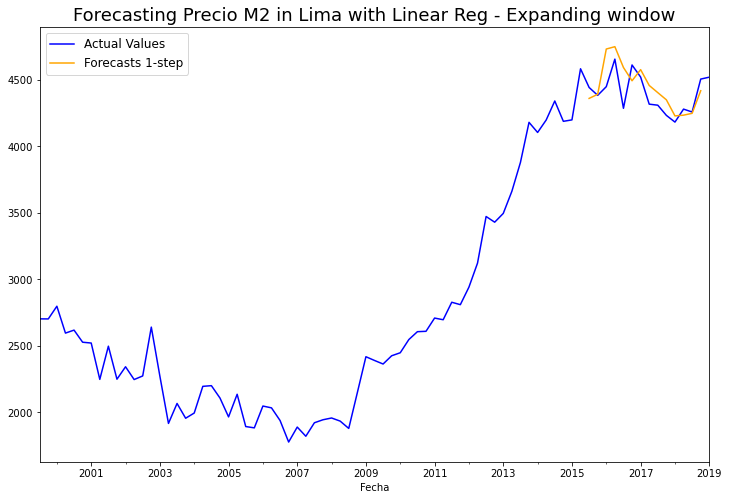

In [11]:
pred_df = pd.DataFrame({date: np.exp(np.median(x)) for date,x in predictions_dict.items()},index=[0]).T.rename(columns={0:'preds'})
original_df = pd.DataFrame({date: np.exp(np.median(x)) for date,x in original_values_dict.items()},index=[0]).T.rename(columns={0:'actual'})

df_time_series = pd.concat([pred_df, original_df],axis=1)

original_series = to_train.groupby(['Fecha'])['Precio_m2'].median()
original_series = np.exp(original_series)

#Figure
fig = plt.figure(figsize=(12,8))
original_series.reset_index().set_index('Fecha')['Precio_m2'].plot(color='blue')
df_time_series['preds'].plot(color='orange')
plt.title('Forecasting Precio M2 in Lima with Linear Reg - Expanding window', fontsize=18)
plt.legend(['Actual Values','Forecasts 1-step'],fontsize=12)